<a href="https://colab.research.google.com/github/AyanRoy22/Kaggle-NLP-with-disaster-tweets/blob/main/Kaggle_NLP_with_disaster_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing modules

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import re, string
import spacy
from spacy.lang.en import English
import os
import tensorflow as tf
nlp = spacy.load('en_core_web_sm')

In [21]:
import tensorflow_hub as hub
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
embed = hub.load(model)

In [2]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.2 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=f183ecdeb3f0e124ac5e000befcf0d1a8b4b50adba4d297f473151e106b0b8aa
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


## Loading the dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -q /content/drive/MyDrive/Kaggle/nlp-getting-started.zip

In [36]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [37]:
train[train['target']==1]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [38]:
train[train['target']==0]

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0
...,...,...,...,...,...
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0
7582,10834,wrecked,NaN,Cramer: Iger's 3 words that wrecked Disney's s...,0
7584,10837,NaN,NaN,These boxes are ready to explode! Exploding Ki...,0
7587,10841,NaN,NaN,Sirens everywhere!,0


In [39]:
train["target"].value_counts(normalize = True)

0    0.57034
1    0.42966
Name: target, dtype: float64

## Data Preprocessing

In [40]:
# converting into lowercase
train['keyword'] = train['keyword'].apply(lambda x: str.lower(x) if pd.isna(x) != True else x)
train['location'] = train['location'].apply(lambda x: str.lower(x) if pd.isna(x) != True else x)
train['text'] = train['text'].apply(lambda x: str.lower(x) if pd.isna(x) != True else x)

test['keyword'] = test['keyword'].apply(lambda x: str.lower(x) if pd.isna(x) != True else x)
test['location'] = test['location'].apply(lambda x: str.lower(x) if pd.isna(x) != True else x)
test['text'] = test['text'].apply(lambda x: str.lower(x) if pd.isna(x) != True else x)

In [41]:
# removing # and @
def remove_entities(text):
    entity_prefixes = ['@', '#']
    for separator in string.punctuation:
        if separator not in entity_prefixes:
            text = text.replace(separator, ' ')
    words = [word for word in text.split() if not word.startswith(tuple(entity_prefixes))]
    return ' '.join(words)

In [42]:
train['keyword'] = train['keyword'].apply(lambda x: remove_entities(x) if pd.isna(x) != True else x)
train['location'] = train['location'].apply(lambda x: remove_entities(x) if pd.isna(x) != True else x)
train['text'] = train['text'].apply(lambda x: remove_entities(x) if pd.isna(x) != True else x)

test['keyword'] = test['keyword'].apply(lambda x: remove_entities(x) if pd.isna(x) != True else x)
test['location'] = test['location'].apply(lambda x: remove_entities(x) if pd.isna(x) != True else x)
test['text'] = test['text'].apply(lambda x: remove_entities(x))

In [43]:
# removing url
train['keyword'] = train['keyword'].apply(lambda x: re.sub(r"(?:\@|http?\://|https?\://|www)\S", ' ', x) if pd.isna(x) != True else x)
train['location'] = train['location'].apply(lambda x: re.sub(r"(?:\@|http?\://|https?\://|www)\S", ' ', x) if pd.isna(x) != True else x)
train['text'] = train['text'].apply(lambda x: re.sub(r"(?:\@|http?\://|https?\://|www)\S", ' ', x))

test['keyword'] = test['keyword'].apply(lambda x: re.sub(r"(?:\@|http?\://|https?\://|www)\S", ' ', x) if pd.isna(x) != True else x)
test['location'] = test['location'].apply(lambda x: re.sub(r"(?:\@|http?\://|https?\://|www)\S", ' ', x) if pd.isna(x) != True else x)
test['text'] = test['text'].apply(lambda x: re.sub(r"(?:\@|http?\://|https?\://|www)\S", ' ', x))

In [44]:
# removing punctuation
train['keyword'] = train['keyword'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x) if pd.isna(x) != True else x)
train['location'] = train['location'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x) if pd.isna(x) != True else x)
train['text'] = train['text'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))

test['keyword'] = test['keyword'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x) if pd.isna(x) != True else x)
test['location'] = test['location'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x) if pd.isna(x) != True else x)
test['text'] = test['text'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))

In [45]:
def lemmatize(sentence):
  doc = nlp(sentence)
  lemmas = [token.lemma_ for token in doc]
  return " ".join(lemmas)

In [46]:
train['keyword'] = train['keyword'].apply(lambda x: lemmatize(x) if pd.isna(x) != True else x)
train['location'] = train['location'].apply(lambda x: lemmatize(x) if pd.isna(x) != True else x)
train['text'] = train['text'].apply(lambda x: lemmatize(x))

test['keyword'] = test['keyword'].apply(lambda x: lemmatize(x) if pd.isna(x) != True else x)
test['location'] = test['location'].apply(lambda x: lemmatize(x) if pd.isna(x) != True else x)
test['text'] = test['text'].apply(lambda x: lemmatize(x))

## Word Cloud of the location of tweets

In [47]:
only_loc = train['location'][~train['location'].isna()]
len(only_loc)

5080

In [50]:
wc = WordCloud(width=1200, height=800, max_words=200, background_color='white')

(-0.5, 1199.5, 799.5, -0.5)

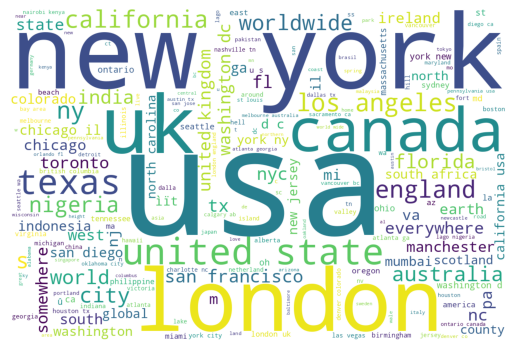

In [51]:
plt.imshow(wc.generate_from_text(' '.join(only_loc)))
plt.axis('off')

## Word Cloud of the tweets

In [62]:
txt = train['text']
len(txt)

7613

(-0.5, 1199.5, 799.5, -0.5)

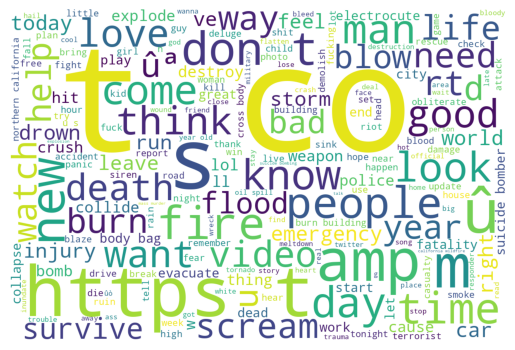

In [63]:
plt.imshow(wc.generate_from_text(' '.join(txt)))
plt.axis('off')

### Filling up missing data using keyword extraction

In [54]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [55]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [56]:
# for keywords
def extract_keywords(nlp = nlp, doc="", no_of_keywords=5, model=model):
  doc = doc.lower()
  doc = re.sub(r"(?:\@|http?\://|https?\://|www)\S", ' ', doc)
  doc = re.sub(r'[^\w\s]', ' ', doc)
  doc = re.sub(' \d+', ' ', doc)

  doc_ = nlp(doc)

  pos_tag = ['VERB', 'NOUN', 'ADJ', 'PROPN']
  result = []

  for token in doc_:
    if(token.pos_ in pos_tag):
      result.append(token.text)

  doc_embedding = model.encode([doc])
  results_embedding = model.encode(result)

  distances = cosine_similarity(doc_embedding, results_embedding)
  keywords = [result[index] for index in distances.argsort()[0][-no_of_keywords:]]

  return keywords

In [57]:
# filling the missing data
for i in range(len(train['keyword'])):
  if pd.isnull(train['keyword'].iloc[i]):
    try:
      train['keyword'].iloc[i] = extract_keywords(nlp=nlp, doc=train.text.iloc[i], no_of_keywords=1, model=model)[0]
    except:
      train['keyword'].iloc[i] = "NaN"

for i in range(len(test['keyword'])):
  if pd.isnull(test['keyword'].iloc[i]):
    try:
      test['keyword'].iloc[i] = extract_keywords(nlp=nlp, doc=train.text.iloc[i], no_of_keywords=1, model=model)[0]
    except:
      test['keyword'].iloc[i] = "NaN"

<ipython-input-57-19d87fef38d9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['keyword'].iloc[i] = "NaN"
<ipython-input-57-19d87fef38d9>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['keyword'].iloc[i] = "NaN"


In [58]:
# for location
def get_location(nlp=nlp, doc=""):
  doc_ = nlp(doc)

  location = ""

  for ent in doc_.ents:
    if ent.label_ in ["GPE", "ORG"]:
      location = location + ent.text + " "
  return location

In [59]:
for i in range(len(train['location'])):
  if pd.isnull(train['location'].iloc[i]):
    try:
      train['location'].iloc[i] = extract_keywords(nlp=nlp, doc=train.text.iloc[i], no_of_keywords=1, model=model)[0]
    except:
      train['location'].iloc[i] = "NaN"

for i in range(len(test['location'])):
  if pd.isnull(test['location'].iloc[i]):
    try:
      test['location'].iloc[i] = extract_keywords(nlp=nlp, doc=train.text.iloc[i], no_of_keywords=1, model=model)[0]
    except:
      test['location'].iloc[i] = "NaN"

<ipython-input-59-66ce62f1253f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['location'].iloc[i] = "NaN"
<ipython-input-59-66ce62f1253f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['location'].iloc[i] = "NaN"


In [60]:
# removing stopwords
nlp = spacy.load('en_core_web_sm')

def remove_stopwords(sentence):
  doc = nlp(sentence)
  all_stopwords = nlp.Defaults.stop_words
  doc_tokens = [token.text for token in doc]
  tokens_wo_stopwords = [word for word in doc_tokens if not word in all_stopwords]
  return " ".join(tokens_wo_stopwords)

In [61]:
train['keyword'] = train['keyword'].apply(lambda x: remove_stopwords(x) if pd.isna(x) != True else x)
train['location'] = train['location'].apply(lambda x: remove_stopwords(x) if pd.isna(x) != True else x)
train['text'] = train['text'].apply(lambda x: remove_stopwords(x))

test['keyword'] = test['keyword'].apply(lambda x: remove_stopwords(x) if pd.isna(x) != True else x)
test['location'] = test['location'].apply(lambda x: remove_stopwords(x) if pd.isna(x) != True else x)
test['text'] = test['text'].apply(lambda x: remove_stopwords(x))

# Model

In [29]:
from sklearn.utils import shuffle

train = shuffle(train, random_state=42).reset_index(drop=True)
y = np.array(train['target'].tolist())

key_embed = embed(train.keyword.to_list())
loc_embed = embed(train.location.to_list())
text_embed = embed(train.text.to_list())

In [30]:
from tensorflow.keras.layers import Input, Dense, Flatten, concatenate, Dropout
from tensorflow.keras import Model

keyword_input = Input(shape=(key_embed.shape[1],))
location_input = Input(shape=(loc_embed.shape[1],))
text_input = Input(shape=(text_embed.shape[1],))

# keyword model
key_model = Flatten()(keyword_input)
key_model = Dense(1024, activation='relu')(keyword_input)
key_model = Dropout(0.5)(keyword_input)

# location model
loc_model = Flatten()(location_input)
loc_model = Dense(1024, activation='relu')(location_input)
loc_model = Dropout(0.5)(location_input)

# text model
text_model = Flatten()(text_input)
text_model = Dense(1024, activation='relu')(text_input)
text_model = Dropout(0.5)(text_input)

merged = concatenate([key_model, loc_model, text_model], axis=1)
merged = Dense(1024, activation='relu')(merged)
merged = Dropout(0.5)(merged)
final = Dense(1, activation = 'sigmoid')(merged)

final = Model(inputs = [keyword_input, location_input, text_input], outputs=final)

In [31]:
lr = 0.1  #learning rate
epochs = 100
opt = tf.keras.optimizers.legacy.SGD(lr = lr, momentum = 0.8, decay = lr/epochs)

final.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)

hist = final.fit(
    x = [key_embed, loc_embed, text_embed],
    y = y,
    batch_size = 32,
    epochs = epochs,
    validation_split = 0.1,
    callbacks = [earlystop]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


215/215 [==============================] - 1s 3ms/step - loss: 0.5977 - accuracy: 0.6781 - val_loss: 0.5333 - val_accuracy: 0.7375
Epoch 2/100
215/215 [==============================] - 1s 3ms/step - loss: 0.5685 - accuracy: 0.7071 - val_loss: 0.5249 - val_accuracy: 0.7598
Epoch 3/100
215/215 [==============================] - 1s 3ms/step - loss: 0.5581 - accuracy: 0.7165 - val_loss: 0.5319 - val_accuracy: 0.7585
Epoch 4/100
215/215 [==============================] - 1s 3ms/step - loss: 0.5535 - accuracy: 0.7291 - val_loss: 0.5184 - val_accuracy: 0.7664
Epoch 5/100
215/215 [==============================] - 1s 3ms/step - loss: 0.5420 - accuracy: 0.7304 - val_loss: 0.5164 - val_accuracy: 0.7703
Epoch 6/100
215/215 [==============================] - 1s 3ms/step - loss: 0.5412 - accuracy: 0.7297 - val_loss: 0.5114 - val_accuracy: 0.7638
Epoch 7/100
215/215 [==============================] - 1s 3ms/step - loss: 0.5403 - accuracy: 0.7308 - val_loss: 0.5098 - val_accuracy: 0.7730
Epoch 8/100